# A Toxicology Experiment on the Death of Beetles
### by Diana Gerardo Fall 2018
## A Bayesian Approach

Continuation of part 2 

Code implemented in google colab

**c)** As a third model, consider the binomial GLM with the parametric link
given in (1). Develop an MCMC method to sample from the posterior
distribution of $(\beta_{1},\beta_{2},\alpha)$, and obtain the posterior
distribution for $LD_{50}$, and point and interval estimates for
$\pi(x)$.

In [5]:
#  !pip install torch

In [6]:
# !pip install pyro-ppl

     |████████████████████████████████| 634kB 4.2MB/s eta 0:00:01


In [50]:
import numpy as np
import torch
from scipy.stats import binom
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scipy
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import NUTS, HMC
from pyro.infer import MCMC, NUTS, HMC

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
def modlogit(theta, a):
    # generalized logit function
    numerator = torch.exp(a*theta)
    denominator = 1+ torch.exp(theta)  
    return numerator/(denominator**a)

def glm(X, y, numTrials):
    N = y.shape[0]
    
    # Priors.
    beta0 = pyro.sample('beta0', dist.Normal(0, 100))
    beta1 = pyro.sample('beta1', dist.Normal(0, 100))
    alpha = pyro.sample('alpha', dist.Gamma(1, 1))
    theta_p = modlogit(beta0 + beta1*X, alpha)
    
    with pyro.plate('response', N):
        pyro.sample('obs', dist.Binomial(total_count = numTrials, probs = theta_p), obs = y)

In [10]:
log_dose = np.array([1.6907,1.7242,1.7552,1.7842,1.8113,1.8369,1.8610,1.8839]) # X_train
weights = np.array([59,60,62,56,63,59,62,60]) # m_train, num_beetles
num_died = np.array([6,13,18,28,52,53,61,60]) # y_train

In [11]:
X = torch.from_numpy(log_dose)
m = torch.from_numpy(weights)
y = torch.from_numpy(num_died)

In [12]:
# HMC
pyro.clear_param_store() # clear global parameter cache.
pyro.set_rng_seed(2) # set random number generator seed.

nuts = MCMC(NUTS(glm, target_accept_prob = 0.65, max_tree_depth = 7, jit_compile = True), num_samples = 10000, warmup_steps = 500)
nuts.run(X = X, y = y, numTrials = m)

Sample: 100%|██████████| 10500/10500 [21:16,  8.23it/s, step size=1.37e-02, acc. prob=0.876]


In [13]:
nuts.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0   -112.38     25.65   -110.18   -152.08    -70.12    249.74      1.00
     beta1     61.87     13.84     60.68     38.97     83.23    250.05      1.00
     alpha      0.33      0.13      0.30      0.15      0.52    352.50      1.00

Number of divergences: 0


In [14]:
nuts_posterior_samples = nuts.get_samples()
nuts_posterior_samples.keys()

dict_keys(['beta0', 'beta1', 'alpha'])

In [15]:
def convergence_plot(arr, color, title, xlab, ylab):
    for i in range(len(title)):
        plt.plot(arr[i], color = color)
        plt.title(title[i])
        plt.xlabel(xlab)
        plt.ylabel(ylab[i])
        plt.show()

def density_plot(arr, color, title, xlab):
    for i in range(len(title)):
        sns.kdeplot(arr[i], color = color, shade = True, lw = 1.5
                       ).set(ylabel='Density', xlabel = xlab[i], title = title[i])
        plt.show()

In [16]:
samps = [nuts_posterior_samples['beta0'].numpy(), nuts_posterior_samples['beta1'].numpy(),
         nuts_posterior_samples['alpha'].numpy()]
den_titles = ["Density of Intercept $\u03B2_{0}$", "Density of Intercept $\u03B2_{1}$",
          "Density of Intercept $\u03B1$"]
convergence_titles = ["Convergence of Intercept $\u03B2_{0}$", "Convergence of Intercept $\u03B2_{1}$",
          "Convergence of Intercept $\u03B1$"]
labs = ["$\u03B2_{0}$", "$\u03B2_{1}$", "$\u03B1$"]

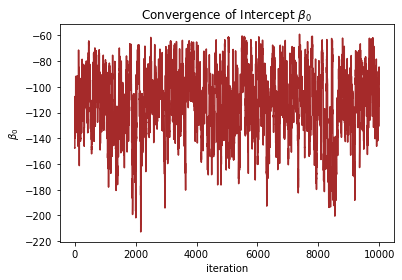

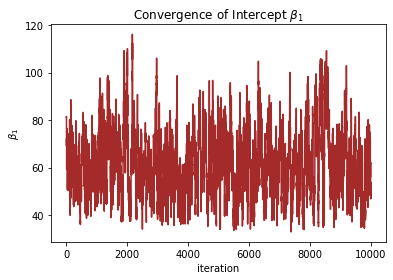

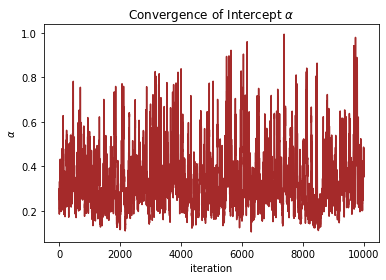

In [17]:
convergence_plot(samps, "brown", convergence_titles, "iteration", labs)

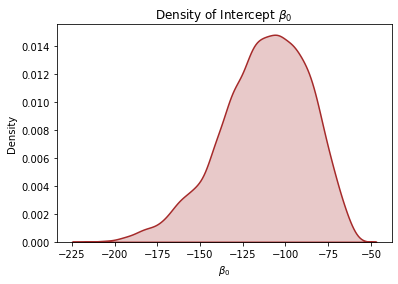

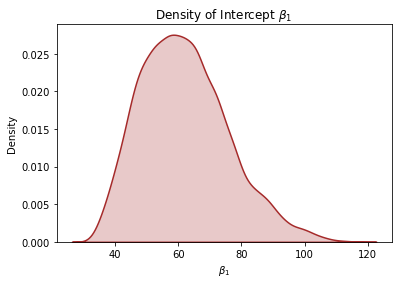

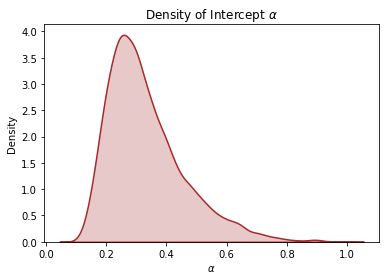

In [18]:
density_plot(samps, "brown", den_titles, labs)

In [19]:
def modlogit_fucntion(x,b):
    Xb = (b[0]+b[1]*x)
    numer = np.exp(Xb)
    denom = (1 + np.exp(Xb) )
    val = (numer/denom)**b[2]
    
    return val 

def quantile_function(grid, betas, quantiles_to_compute):
    q = np.zeros(shape=(len(quantiles_to_compute), len(grid)))
    
    for i in range(100):
        new_pi = modlogit_fucntion(x_grid[i], betas)
        q[:,i] = np.quantile(new_pi, quantiles_to_compute)
    
    return q

In [20]:
x_grid = np.linspace(start=1.65, stop=1.9, num=100)
quants = [0.025,0.5,0.975]
conf_int = quantile_function(x_grid, samps, quants) 

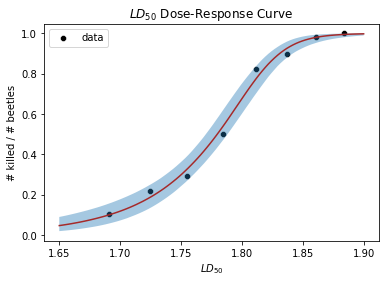

In [21]:
sns.lineplot(x = x_grid, y = conf_int[1,:], color = "brown")
sns.scatterplot(x = log_dose, y = num_died/weights, color = "black", label = "data"
                   ).set(title = "$LD_{50}$ Dose-Response Curve", ylabel = "# killed / # beetles", xlabel = "$LD_{50}$")
plt.fill_between(x_grid,conf_int[2,:],conf_int[0,:], alpha = .4)

In [22]:
# print the avg posterior estimates 
def posterior_means(samples):
  avgs = np.zeros(shape=(len(samples)))
  
  for i in range(len(samples)):
    mean = np.mean(samples[i])
    avgs[i] = np.round (mean,2)
  
  return(avgs)

In [23]:
mean_samps = posterior_means(samps) #b0, b1, alpha respectively

In [24]:
modlogit_residuals = (y/m) - modlogit_fucntion(X,mean_samps)

<function matplotlib.pyplot.show>

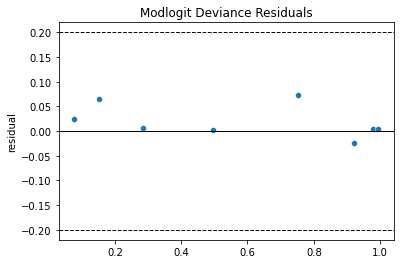

In [25]:
sns.scatterplot(x = modlogit_fucntion(X,mean_samps), y = modlogit_residuals
                   ).set(ylabel= 'residual', title='Modlogit Deviance Residuals')
plt.axhline(0.2, color = 'black', ls = '--', lw = 1)
plt.axhline(0, color = 'black', ls = '-', lw = 1)
plt.axhline(-0.2, color = 'black', ls = '--', lw = 1)
plt.show

In [47]:
def modlogit_function(x,b0,b1,a):
    Xb = (b0+b1*x)
    numer = np.exp(Xb)
    denom = (1 + np.exp(Xb) )
    val = (numer/denom)**a

    return val

# drawing from the predicitve distribution
def predictive(x, b0,b1,a, weights):
    num_obs = len(weights)
    iters = len(b0)
    predictive_draws = np.zeros(shape=(num_obs, iters))
    
    for i in range(iters):
        pi = modlogit_function(x, b0[i], b1[i],a[i])
        
        for j in range(num_obs):
            predictive_draws[j,i] = scipy.binom.rvs(n = weights[j], p = pi[j] , size = 1)
        
    return predictive_draws

In [48]:
beta0 = nuts_posterior_samples['beta0'].numpy()
beta1 = nuts_posterior_samples['beta1'].numpy()
alpha = nuts_posterior_samples['alpha'].numpy()

In [51]:
pred_draws = predictive(log_dose, beta0, beta1, alpha, weights)
pred_draws.shape

(8, 10000)

In [53]:
# Gelfand and Gosh Criterion (posterior predictive quad loss)

def gg(obs_var, preds):
    y = obs_var
    
    means = preds.mean(axis=1)
    inside_sum1 = (y - means)**2
    
    variance = preds.var(axis=1)
    
    return np.sum(inside_sum1) + np.sum(variance)

In [54]:
gg(num_died, pred_draws)

107.67050000000002